In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import os
import seaborn as sns


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Simple Problem with One Confounder (Smoker)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ISSS623-AHA/Lecture---Hands-on-Codes/main/Lecture%202/sample.csv")
df = df.sample(10000)
df = df.reset_index(drop=True)
df

,smoker,treatment,dead
0,0,0,0
1,0,1,0
2,1,1,0
3,1,1,1
4,0,0,0
...,...,...,...
9995,0,0,0
9996,1,1,0
9997,0,0,0
9998,0,0,0


## 1.1 Simple Analysis Without Knowledge of Confounders

How much will the proportion of dead change if we were to treat everyone (ignoring whether they are smokers)?

In [3]:
treated = df[df["treatment"]==1]
untreated = df[df["treatment"]==0]

In [4]:
percentage_dead_treated = treated["dead"].mean()
percentage_dead_treated

0.3130917401240614

In [5]:
percentage_dead_untreated= untreated["dead"].mean()
percentage_dead_untreated

0.2355485080005766

In [6]:
ATE1=percentage_dead_treated - percentage_dead_untreated
print('ATE=',ATE1)

ATE= 0.07754323212348477


The proportion of dead increase by 8.5% if we were to treat everyone? Hence, we should stop the treatment immediately?

## 1.2 Using Basic Propensity Score based on 1 confounder

Find P(Treated|smoker)

In [7]:
n_smokers = len(df[df["smoker"]==1])
n_treated_smokers = len(df[(df["smoker"]==1) & (df["treatment"]==1)])
p_treated_smokers = n_treated_smokers/n_smokers
print(p_treated_smokers)

0.5569282136894824


Find P(Treated|non-smoker)

In [8]:
n_non_smokers = len(df[df["smoker"]==0])
n_treated_non_smokers = len(df[(df["smoker"]==0) & (df["treatment"]==1)])
p_treated_non_smokers = n_treated_non_smokers/n_non_smokers
print(p_treated_non_smokers)

0.19914346895074947


Assign Propensity Score to each subject

In [9]:
df["propensity"] = df["smoker"]*p_treated_smokers + (1-df["smoker"])*p_treated_non_smokers #
df

,smoker,treatment,dead,propensity
0,0,0,0,0.199143
1,0,1,0,0.199143
2,1,1,0,0.556928
3,1,1,1,0.556928
4,0,0,0,0.199143
...,...,...,...,...
9995,0,0,0,0.199143
9996,1,1,0,0.556928
9997,0,0,0,0.199143
9998,0,0,0,0.199143


Matching each treated patient with a counterfactual untreated person with the same propensity score with random sampling from the untreated patients

In [10]:
treated = df[df["treatment"]==1].sample(1000)
untreated = df[df["treatment"]==0]

treated = treated.reset_index(drop=True)
matched_control=[]

def add_matched_control(patient):
    control_patient = untreated[untreated["propensity"]==patient["propensity"]].sample().iloc[0]
    matched_control.append(control_patient)
    
treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
matched_control_df

,smoker,treatment,dead,propensity
0,0.0,0.0,0.0,0.199143
1,1.0,0.0,1.0,0.556928
2,1.0,0.0,0.0,0.556928
3,1.0,0.0,1.0,0.556928
4,0.0,0.0,0.0,0.199143
...,...,...,...,...
995,1.0,0.0,0.0,0.556928
996,0.0,0.0,1.0,0.199143
997,1.0,0.0,1.0,0.556928
998,1.0,0.0,1.0,0.556928


In [11]:
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample

,smoker,treatment,dead,propensity,smoker_control,treatment_control,dead_control,propensity_control
0,0,1,1,0.199143,0.0,0.0,0.0,0.199143
1,1,1,0,0.556928,1.0,0.0,1.0,0.556928
2,1,1,1,0.556928,1.0,0.0,0.0,0.556928
3,1,1,1,0.556928,1.0,0.0,1.0,0.556928
4,0,1,0,0.199143,0.0,0.0,0.0,0.199143
...,...,...,...,...,...,...,...,...
995,1,1,0,0.556928,1.0,0.0,0.0,0.556928
996,0,1,0,0.199143,0.0,0.0,1.0,0.199143
997,1,1,1,0.556928,1.0,0.0,1.0,0.556928
998,1,1,0,0.556928,1.0,0.0,1.0,0.556928


In [12]:
ATE2 = (paired_sample["dead"]-paired_sample["dead_control"]).mean()
print('ATE=',ATE2)

ATE= -0.154


The percentage of death is now estimated to be lower for treatment compared to no treatment. There is a reversal of the association.

There is certainly some bias, but there are sophisticated methods to deal with them in Propensity Score technique. The way to do the matching is also another factor. There are many ways to do so.

# 1.3 Using Subclassification for 1 Confounder for matching

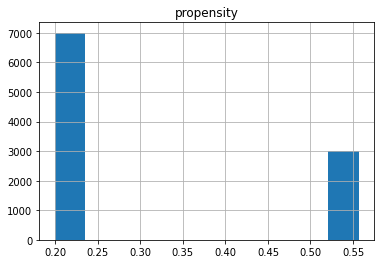

In [13]:
# There are 2 groups of propensity scores (obviously)
df.hist("propensity")
pass

In [14]:
# Define the 2 groups as high and low propensity
high_propensity = df[df["propensity"]==p_treated_smokers]
low_propensity = df[df["propensity"]==p_treated_non_smokers]

# Compute percentage in each propensity group
counts = np.array([len(low_propensity),len(high_propensity)])
percentages= counts / np.sum(counts)
percentages

array([0.7005, 0.2995])

In [15]:
low_propensity_treated = low_propensity[low_propensity["treatment"]==1]
low_propensity_untreated = low_propensity[low_propensity["treatment"]==0]
ATE_low_propensity = low_propensity_treated["dead"].mean()-low_propensity_untreated["dead"].mean()
ATE_low_propensity

0.002888467214842927

In [16]:
high_propensity_treated = high_propensity[high_propensity["treatment"]==1]
high_propensity_untreated = high_propensity[high_propensity["treatment"]==0]
ATE_high_propensity = high_propensity_treated["dead"].mean()-high_propensity_untreated["dead"].mean()
ATE_high_propensity

-0.3064005464806753

In [17]:
# Find the weighted average across both groups (less biased)

ATE3 = percentages[0] * ATE_low_propensity + percentages[1] * ATE_high_propensity
print('ATE=',ATE3)

# NOTE: Theoretical ATE given the generating function for the random variables is 0.083

ATE= -0.08974359238696476


# 2. Using Logistic Regression to estimate Propensity Scores for problem with multiple confounders
- Example is based on Vanderbilt Right Heart Cathetherization Dataset
- Dataset description: https://biostat.app.vumc.org/wiki/pub/Main/DataSets/Crhc.html

In [20]:
rhc=pd.read_csv('https://raw.githubusercontent.com/ISSS623-AHA/Lecture---Hands-on-Codes/main/Lecture%202/rhc.csv')

In [21]:
rhc.columns

Index(['Unnamed: 0', 'cat1', 'cat2', 'ca', 'sadmdte', 'dschdte', 'dthdte',
       'lstctdte', 'death', 'cardiohx', 'chfhx', 'dementhx', 'psychhx',
       'chrpulhx', 'renalhx', 'liverhx', 'gibledhx', 'malighx', 'immunhx',
       'transhx', 'amihx', 'age', 'sex', 'edu', 'surv2md1', 'das2d3pc',
       't3d30', 'dth30', 'aps1', 'scoma1', 'meanbp1', 'wblc1', 'hrt1', 'resp1',
       'temp1', 'pafi1', 'alb1', 'hema1', 'bili1', 'crea1', 'sod1', 'pot1',
       'paco21', 'ph1', 'swang1', 'wtkilo1', 'dnr1', 'ninsclas', 'resp',
       'card', 'neuro', 'gastr', 'renal', 'meta', 'hema', 'seps', 'trauma',
       'ortho', 'adld3p', 'urin1', 'race', 'income', 'ptid'],
      dtype='object')

In [22]:
rhc.head()

,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,No,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,Yes,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,No,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,Yes,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,Yes,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11


In [23]:
rhc=rhc.replace(to_replace = 'Yes', value = 1)
rhc=rhc.replace(to_replace = 'No', value = 0)

# Treatment variable: swang1. How many received treatment? 
rhc['swang1'].value_counts(normalize=True)

No RHC    0.61918
RHC       0.38082
Name: swang1, dtype: float64

In [24]:
rhc['treated'] = 0
rhc['treated'] = rhc['treated'].where(rhc.swang1=='No RHC',1)

In [25]:
# Percentage died in the treatment group (percent)
rhc.groupby('treated')['death'].mean()

treated
0    0.629682
1    0.680403
Name: death, dtype: float64

## 2.1 Logistic Regression on the Outcomes and Treatment. For Propensity Score, estimate LR model on the Treatment

In [26]:
# Logistic regression for death (outcome) as dependent variable
model = 'death ~ age + sex + edu + treated'
reg_results = smf.logit(formula=model, data=rhc).fit()
reg_results.summary()

Optimization terminated successfully.
         Current function value: 0.622953
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  death   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5730
Method:                           MLE   Df Model:                            4
Date:                Wed, 20 Jul 2022   Pseudo R-squ.:                 0.03875
Time:                        17:01:56   Log-Likelihood:                -3572.6
converged:                       True   LL-Null:                       -3716.7
Covariance Type:            nonrobust   LLR p-value:                 4.112e-61
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.2474      0.168     -7.406      0.000      -1.577      -0.917
sex[T.Male]     0.1074      0.057      1.878      0.060      -0.005       0.219
age             0.0277      0.002     15.970      0.000       0.024       0.031
edu             0.0030      0.009      0.327      0.743      -0.015       0.021
treated         0.2526      0.059      4.278      0.000       0.137       0.368
===============================================================================
"""

In [27]:
rhc['sex'] = rhc['sex'].replace('Male', 0)
rhc['sex'] = rhc['sex'].replace('Female', 1)

In [28]:
# Logistic regression with Treatment as dependent variable (Propensity score)
model = 'treated ~ age + sex +edu'
propensity = smf.logit(formula=model, data = rhc).fit()
propensity.summary()

# Fit is very poor - this is just a demo as there are many potential confounders in the dataset that can be used

Optimization terminated successfully.
         Current function value: 0.662209
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                treated   No. Observations:                 5735
Model:                          Logit   Df Residuals:                     5731
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Jul 2022   Pseudo R-squ.:                0.003394
Time:                        17:01:57   Log-Likelihood:                -3797.8
converged:                       True   LL-Null:                       -3810.7
Covariance Type:            nonrobust   LLR p-value:                 1.017e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5584      0.157     -3.550      0.000      -0.867      -0.250
age           -0.0027      0.002     -1.648      0.099      -0.006       0.001
sex           -0.1858      0.055     -3.374      0.001      -0.294      -0.078
edu            0.0273      0.009      3.111      0.002       0.010       0.045
==============================================================================
"""

In [29]:
# Estimate propensity score and add to the rhc dataframe
rhc['propensity'] = propensity.predict()

# 2.2 Check the distribution of subjects across variables

treated
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

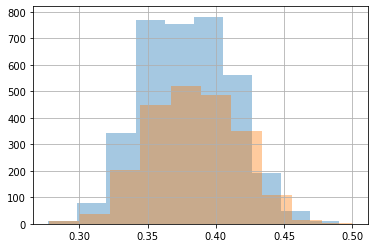

In [30]:
# plot propensity score to compare treated and untreated before matching
rhc.groupby('treated')['propensity'].hist(alpha=0.4)

In [31]:
rhc.groupby('treated')['propensity'].mean()

treated
0    0.379108
1    0.383603
Name: propensity, dtype: float64

In [32]:
# Distributions in the treated and untreated groups
rhc.groupby('treated')['age', 'sex', 'edu'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,age,sex,edu
treated,,,
0,61.760926,0.460997,11.569005
1,60.749836,0.414835,11.856428


In [33]:
rhc[['age', 'sex', 'edu', 'treated','propensity']].sample(10)

,age,sex,edu,treated,propensity
5515,25.56899,1,11.000000,0,0.374461
4435,78.26996,1,13.611382,0,0.357828
4988,83.49597,0,9.000000,1,0.368385
4575,49.89697,1,12.000000,0,0.365441
2407,47.35898,0,14.000000,0,0.424443
3636,67.37598,0,14.000000,0,0.411233
813,82.26099,0,12.000000,1,0.388440
2720,22.68599,1,15.000000,1,0.402258
1966,36.84097,1,12.000000,1,0.373695
3510,68.88397,0,8.000000,0,0.371260


Overview before matching


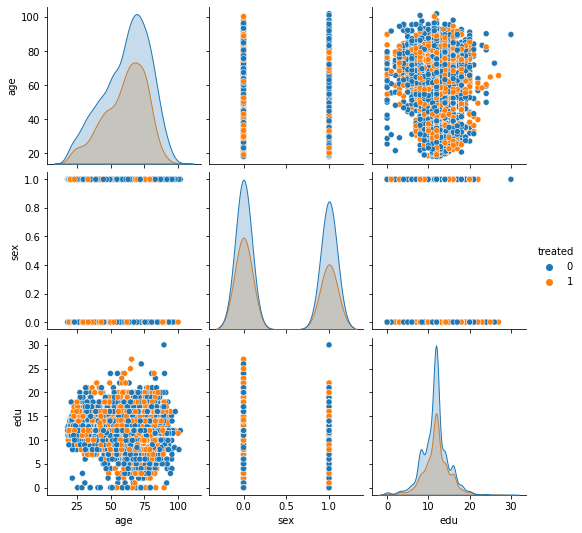

In [34]:
sns.pairplot(data = rhc[['age', 'sex', 'edu', 'treated']], hue = 'treated')
print('Overview before matching')

# 2.3 Simple matching based on Rounding

In [35]:
# Matching based on rounding to first d.p
rhc['group'] = (rhc['propensity']*10).astype(int)

In [36]:
# percentages who die in the different groups
rhc.groupby('group')['death'].mean()

group
2    0.695652
3    0.670981
4    0.595983
5    1.000000
Name: death, dtype: float64

In [37]:
# distinguish between treated and untreated in the different groups and see percentage who die
ps_table=rhc.groupby(['group', 'treated'])['death'].mean().unstack('treated')
ps_table


treated,0,1
group,,
2,0.538462,0.900000
3,0.649882,0.707317
4,0.579317,0.619799
5,NaN,1.000000


In [38]:
rhc_small=rhc[['age', 'sex', 'edu', 'treated','propensity','group','death']]

In [39]:
# Group 5 will not have matches for treated and untreated, so it is dropped
treated = rhc_small.loc[(rhc_small["treated"]==1) & (rhc_small['group']!=5),:]
untreated = rhc_small.loc[(rhc_small["treated"]==0) & (rhc_small['group']!=5),:]

In [40]:
# matching by groups
treated = treated.reset_index(drop=True)
matched_control=[]

def add_matched_control(patient):
    control_patient = untreated[untreated["group"]==patient["group"]].sample().iloc[0]
    matched_control.append(control_patient)

treated.apply(add_matched_control, axis=1)
matched_control_df = pd.DataFrame(matched_control).reset_index(drop=True)
paired_sample = treated.join(matched_control_df, rsuffix="_control")
paired_sample

,age,sex,edu,treated,propensity,group,death,age_control,sex_control,edu_control,treated_control,propensity_control,group_control,death_control
0,78.17896,1,12.000000,1,0.347837,3,1,71.75397,1.0,9.000000,0.0,0.333354,3.0,0.0
1,46.09198,1,14.069916,1,0.381078,3,0,81.17999,1.0,12.000000,0.0,0.345992,3.0,0.0
2,67.90997,0,9.945259,1,0.384368,3,1,69.07599,1.0,8.000000,0.0,0.328915,3.0,1.0
3,48.42398,1,11.040535,1,0.360308,3,0,76.19995,0.0,12.000000,0.0,0.392354,3.0,1.0
4,68.34796,0,12.000000,1,0.397444,3,0,56.85999,1.0,12.000000,0.0,0.361071,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,42.90500,0,11.040535,1,0.407746,4,1,43.50198,0.0,10.000000,0.0,0.400513,4.0,0.0
2179,74.89697,0,9.945259,1,0.379892,3,1,60.41599,1.0,12.000000,0.0,0.358849,3.0,0.0
2180,69.92694,1,9.000000,1,0.334457,3,1,69.17499,0.0,8.000000,0.0,0.371076,3.0,0.0
2181,79.21698,1,8.000000,1,0.322870,3,0,56.00000,1.0,12.000000,0.0,0.361610,3.0,0.0


# 2.4 Step 5: Check the balance of covariates in the exposed and unexposed groups after matching on PS using subclassification

In [41]:
# Check distribution in the treated and untreated groups given (age, edu etc in the different groups)
cov=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated')
cov.dropna(inplace=True)
cov

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


age                  sex                  edu           
treated          0          1         0         1          0          1
group                                                                  
2        79.668124  70.251468  1.000000  1.000000   2.846154   1.700000
3        66.084293  64.332149  0.619591  0.590786  10.725295  10.819763
4        50.493061  53.020573  0.049197  0.034433  13.836182  14.175709

In [42]:
# overall group average
cov_avg=rhc.groupby(['group', 'treated'])['age', 'sex', 'edu'].mean().unstack('treated').mean()
cov_avg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


     treated
age  0          65.415159
     1          63.285035
sex  0           0.556263
     1           0.406305
edu  0           9.135877
     1          13.423868
dtype: float64

In [43]:
# Melt dataframe to plot the comparison of distribution in covariates after matching
paired_sample_treated=paired_sample[['age', 'sex', 'edu', 'treated', 'propensity', 'group','death']]
paired_sample_untreated=paired_sample[['age_control',
       'sex_control', 'edu_control', 'treated_control', 'propensity_control',
       'group_control','death_control']]
paired_sample_untreated.columns = ['age', 'sex', 'edu', 'treated', 'propensity', 'group','death']
paired_sample_long=pd.concat([paired_sample_treated,paired_sample_untreated],ignore_index=True, sort=False)
paired_sample_long

,age,sex,edu,treated,propensity,group,death
0,78.17896,1.0,12.000000,1.0,0.347837,3.0,1.0
1,46.09198,1.0,14.069916,1.0,0.381078,3.0,0.0
2,67.90997,0.0,9.945259,1.0,0.384368,3.0,1.0
3,48.42398,1.0,11.040535,1.0,0.360308,3.0,0.0
4,68.34796,0.0,12.000000,1.0,0.397444,3.0,0.0
...,...,...,...,...,...,...,...
4361,43.50198,0.0,10.000000,0.0,0.400513,4.0,0.0
4362,60.41599,1.0,12.000000,0.0,0.358849,3.0,0.0
4363,69.17499,0.0,8.000000,0.0,0.371076,3.0,0.0
4364,56.00000,1.0,12.000000,0.0,0.361610,3.0,0.0


Overview after matching


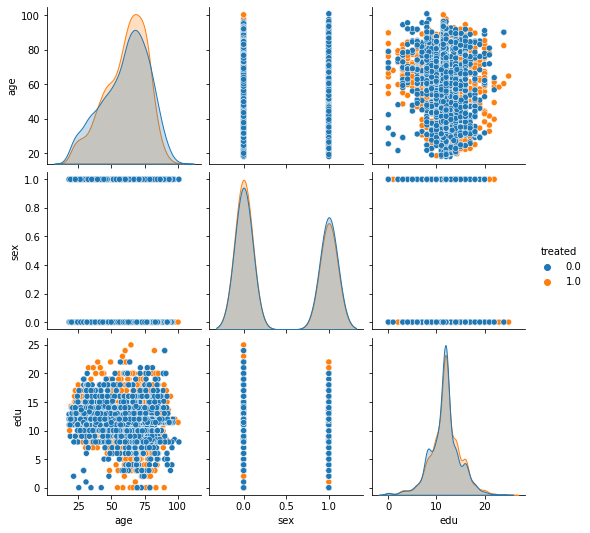

In [44]:
sns.pairplot(data = paired_sample_long[['age', 'sex', 'edu', 'treated']], hue = 'treated')
print('Overview after matching')

In [45]:
matched_ps_table=paired_sample_long.groupby(['group', 'treated'])['death'].mean().unstack('treated')
matched_ps_table

treated,0.0,1.0
group,,
2.0,0.600000,0.900000
3.0,0.626016,0.707317
4.0,0.555237,0.619799


In [46]:
# Evaluate treatment differences for each group
matched_ps_table['difference'] = matched_ps_table[1] - matched_ps_table[0]
matched_ps_table

treated,0.0,1.0,difference
group,,,
2.0,0.600000,0.900000,0.300000
3.0,0.626016,0.707317,0.081301
4.0,0.555237,0.619799,0.064562


In [47]:
# End result, average effect of treatment(ATE) on mortality across all groups
matched_ps_table['difference'].mean()

0.1486210744460386